In [1]:
(* Cellule à exécuter en début de TP pour les tests *)
let () = Random.self_init ();;

module Utils = struct
  let fonction_test nom b =
    let () = print_endline (Printf.sprintf "%s : %s" nom (if b then "\027[1m\027[32mOK\027[0m" else "\027[1m\027[31méchec\027[0m")) in b

  let rec test_liste comp pretty_print f lst  =    
    let rec loop lst ok total =
      match lst with
      | [] -> ok, total
      | (t,tt)::q -> loop q (ok + if fonction_test (pretty_print t) (comp (f t) tt) then 1 else 0) (total + 1) 
    in let ok, total = loop lst 0 0 in print_endline (Printf.sprintf "%i/%i tests réussis" ok total)
     
  let rec test_liste_avec_nom comp f lst = 
    let rec loop lst ok total =
      match lst with
      | [] -> ok, total
      | (nom, t, tt)::q -> loop q (ok + if fonction_test nom (comp (f t) tt) then 1 else 0) (total + 1) 
    in let ok, total = loop lst 0 0 in print_endline (Printf.sprintf "%i/%i tests réussis" ok total)

  let uncurry2 f (x,y) = f x y      
  let uncurry3 f (x,y,z) = f x y z

  let print_int_liste l = List.map string_of_int  l |> String.concat "; " |> Printf.sprintf "[%s]"      
  let print_int_array a = Array.to_list a |> List.map string_of_int |> String.concat "; " |> Printf.sprintf "[|%s|]"
  let print_poly a = Array.to_list a |> List.mapi (fun i a -> string_of_int a ^"X^"^(string_of_int i)) |> String.concat "+"
end 

module TestHash = struct     
  let hash_int f = 
    let pretty_print (m, k) = Printf.sprintf "%i mod %i" k  m in
    let tests = [((7,7), 0); ((5,7),2) ; ((7, 5), 5)] in Utils.test_liste (=) pretty_print (Utils.uncurry2 f) tests
  let int_of_string f =
    let tests = [("bas",7561570); ("haut", 1953849704)] in
    Utils.test_liste (=) (fun x-> x) f tests
  let hash_string f =
    let pretty_print (l, s) = Printf.sprintf "%s, largeur %i" s l in
    let tests = [((125,"anticonstitutionnel"), 78); ((125,"anticonstitutionnellement"), 83)] in
    Utils.test_liste (=) pretty_print (Utils.uncurry2 f) tests
end

module Utils :
  sig
    val fonction_test : string -> bool -> bool
    val test_liste :
      ('a -> 'b -> bool) ->
      ('c -> string) -> ('c -> 'a) -> ('c * 'b) list -> unit
    val test_liste_avec_nom :
      ('a -> 'b -> bool) -> ('c -> 'a) -> (string * 'c * 'b) list -> unit
    val uncurry2 : ('a -> 'b -> 'c) -> 'a * 'b -> 'c
    val uncurry3 : ('a -> 'b -> 'c -> 'd) -> 'a * 'b * 'c -> 'd
    val print_int_liste : int list -> string
    val print_int_array : int array -> string
    val print_poly : int array -> string
  end


module TestHash :
  sig
    val hash_int : (int -> int -> int) -> unit
    val int_of_string : (string -> int) -> unit
    val hash_string : (int -> string -> int) -> unit
  end


# Dictionnaires et arbres binaires de recherche

Un *arbre binaire de recherche* est un arbre binaire dont les étiquettes appartiennent à un ensemble $X$ ordonné et tel que pour tout nœud $N$, l'étiquette de $N$ est supérieure ou égale à toutes les étiquettes présentes dans le fils gauche de $N$ et inférieure ou égale à toutes les étiquettes présentes dans le fils droit de $N$.


<font size="5">❓</font>
Parmi les trois arbres suivants, lesquels sur des arbres binaires de recherche ?<br/><br/>

<figure style="float: left; width: 32%; margin-right: 1%; margin-bottom: 0.5em;    border: thin #c0c0c0 solid;">
    <figcaption style="
    font: smaller sans-serif;
    padding: 3px;
    text-align: center;">Arbre n°1</figcaption>
    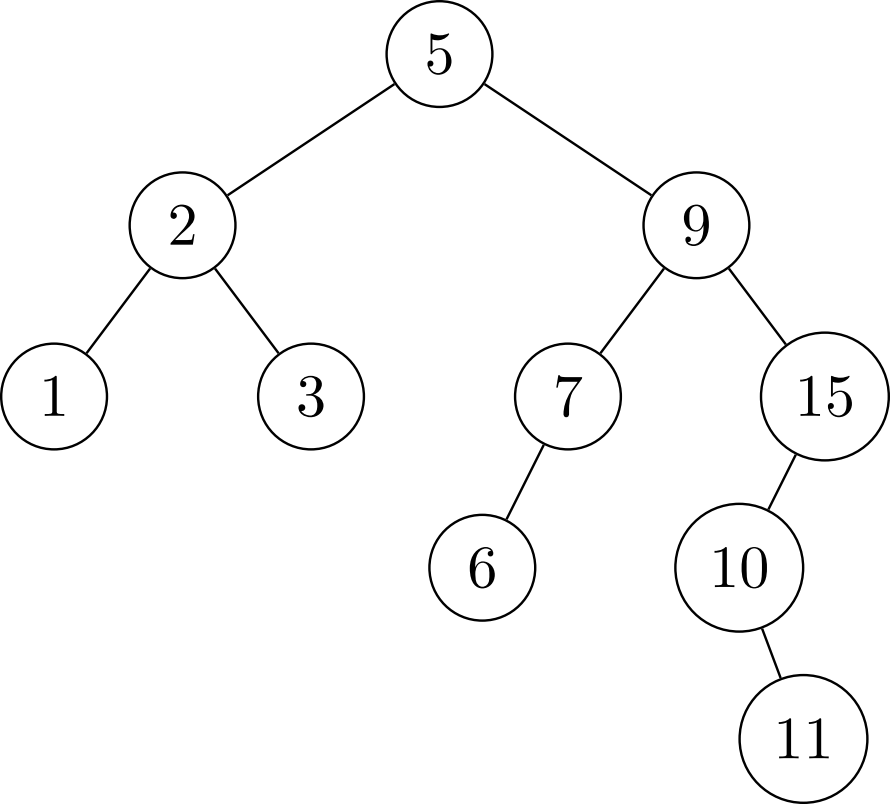
</figure>

<figure style="float: left; width: 32%; margin-right: 1%; margin-bottom: 0.5em;    border: thin #c0c0c0 solid;">
    <figcaption style="
    font: smaller sans-serif;
    padding: 3px;
    text-align: center;">Arbre n°2</figcaption>
    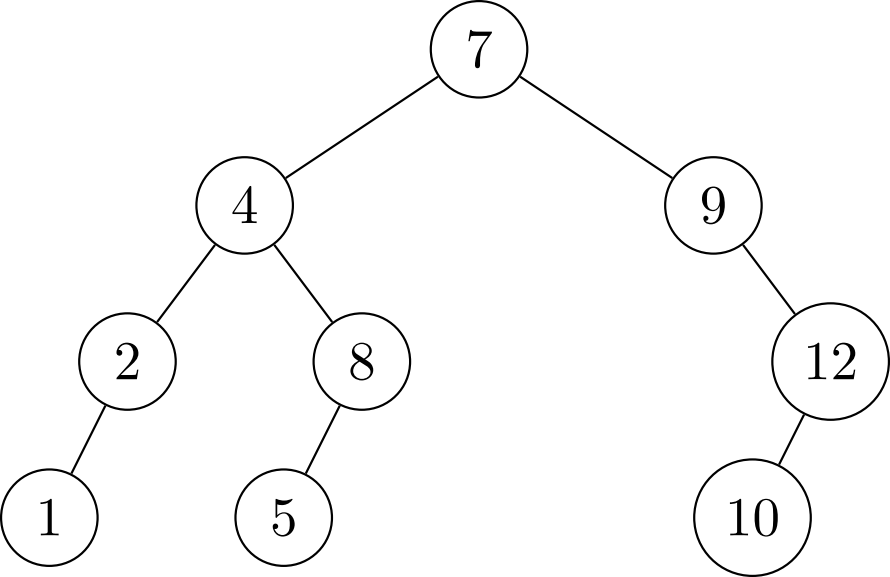
</figure>

<figure style="float: left; width: 32%; margin-right: 1%; margin-bottom: 0.5em;    border: thin #c0c0c0 solid;">
    <figcaption style="
    font: smaller sans-serif;
    padding: 3px;
    text-align: center;">Arbre n°3</figcaption>
    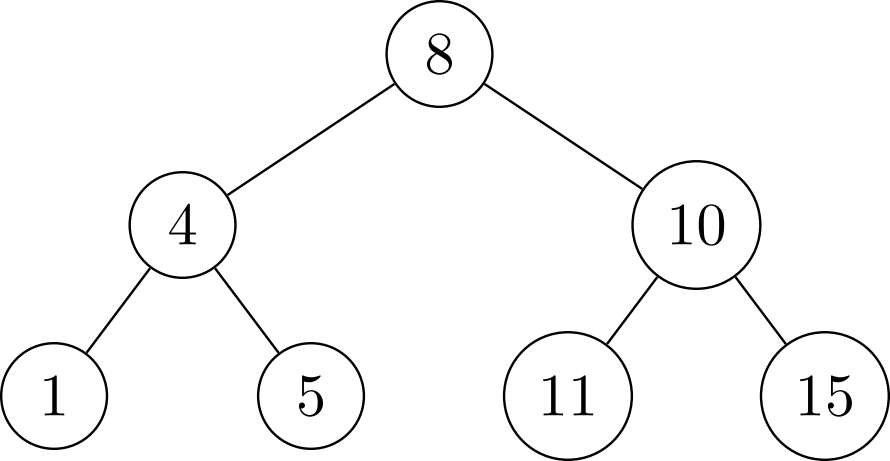
</figure>


✍️ *Votre réponse*

Dans la suite, nous allons utiliser la structure d'arbre binaire de recherche pour implémenter une structure immuable de dictionnaire. L'ordre sur les étiquettes sera celui sur les clés.

On définit pour cela deux types : un type enregistrement `entree` qui servira à décrire chacune des entrées du dictionnaire, et un type arborescent `dico_abr` afin de construire des dictionnaires.

In [3]:
type ('a, 'b) entree = {cle : 'a ; valeur : 'b};;

type ('a, 'b) dico_abr =
  | Vide
  | Noeud of ('a, 'b) entree * ('a, 'b)  dico_abr * ('a, 'b)  dico_abr
;;

type ('a, 'b) entree = { cle : 'a; valeur : 'b; }


type ('a, 'b) dico_abr =
    Vide
  | Noeud of ('a, 'b) entree * ('a, 'b) dico_abr * ('a, 'b) dico_abr


La cellule suivante sert à charger les fonctions nécessaires à l'exécution des tests de cette partie. N'oubliez donc pas de l'exécuter.

In [4]:
module TestABR = struct  
    let arbre1 = Noeud ({cle = 5; valeur = None}, Noeud ({cle = 2; valeur = None}, Noeud ({cle = 1; valeur = None}, Vide, Vide), Noeud ({cle = 3; valeur = None}, Vide, Vide) ), Noeud ({cle = 9; valeur = None}, Noeud ({cle = 7; valeur = None}, Noeud({cle = 6; valeur = None}, Vide, Vide), Vide), Noeud({cle = 15; valeur = None}, Noeud({cle = 10; valeur = None}, Vide, Noeud({cle = 11; valeur = None}, Vide, Vide)), Vide)))
    let arbre2 = Noeud ({cle = 7; valeur = None}, Noeud({cle = 4; valeur = None}, Noeud({cle = 2; valeur = None}, Noeud ({cle = 1; valeur = None}, Vide, Vide), Vide), Noeud({cle = 8; valeur = None}, Noeud ({cle = 5; valeur = None}, Vide, Vide), Vide)), Noeud({cle = 9; valeur = None},Vide, Noeud({cle = 12; valeur = None}, Noeud({cle = 10; valeur = None}, Vide, Vide), Vide)))
    let arbre3 = Noeud ({cle = 8; valeur = None}, Noeud({cle = 4; valeur = None}, Noeud({cle = 1; valeur = None}, Vide,Vide), Noeud({cle = 5; valeur = None}, Vide, Vide)), Noeud({cle = 10; valeur = None},Noeud({cle = 11; valeur = None}, Vide, Vide),Noeud({cle = 15; valeur = None}, Vide, Vide)))
    
    let rec parcours a = match a with | Vide -> [] | Noeud (e, fg, fd) -> parcours fg @ (e::parcours fd)
  
    let est_abr f = let tests = [("Arbre 1", arbre1, true);("Arbre 2", arbre2,false);("Arbre 3", arbre3,false)] in Utils.test_liste_avec_nom (=) f tests

    let trouve f =
      let dico = Noeud ({cle = 5; valeur = "Baleine"}, Noeud ({cle = 2; valeur = "Antilope"}, Noeud ({cle = 1; valeur = "Papillon"}, Vide, Vide), Noeud ({cle = 3; valeur = "Oie"}, Vide, Vide)), Noeud ({cle = 9; valeur = "Méduse"}, Noeud ({cle = 7; valeur = "Loup"}, Noeud({cle = 6; valeur = "Iguane"}, Vide, Vide), Vide),Noeud({cle = 15; valeur = "Ours"}, Noeud({cle = 10; valeur = "Ara"}, Vide, Noeud({cle = 11; valeur = "Perruche"}, Vide, Vide)), Vide))) in 
      let tests = [("Clé présente", (6, dico), Some "Iguane") ; ("Clé présente", (15, dico), Some "Ours") ; ("Clé absente", (4, dico), None)]  in Utils.test_liste_avec_nom (=) (Utils.uncurry2 f) tests

    let ajoute f = 
      let dico0 = Noeud ({cle = 5; valeur = "Baleine"}, Noeud ({cle = 2; valeur = "Antilope"}, Noeud ({cle = 1; valeur = "Papillon"}, Vide, Vide), Noeud ({cle = 3; valeur = "Oie"}, Vide, Vide)), Noeud ({cle = 9; valeur = "Méduse"}, Noeud ({cle = 7; valeur = "Loup"}, Noeud({cle = 6; valeur = "Iguane"}, Vide, Vide), Vide),Noeud({cle = 15; valeur = "Ours"}, Noeud({cle = 10; valeur = "Ara"}, Vide, Noeud({cle = 11; valeur = "Perruche"}, Vide, Vide)), Vide))) in
      let dico1 = f 0 "Lapin" dico0 in let liste1 = [{cle = 0; valeur = "Lapin"}; {cle = 1; valeur = "Papillon"}; {cle = 2; valeur = "Antilope"}; {cle = 3; valeur = "Oie"}; {cle = 5; valeur = "Baleine"}; {cle = 6; valeur = "Iguane"}; {cle = 7; valeur = "Loup"}; {cle = 9; valeur = "Méduse"}; {cle = 10; valeur = "Ara"}; {cle = 11; valeur = "Perruche"}; {cle = 15; valeur = "Ours"}] in
      let dico2 = f 42 "Ornithorynque" dico1 in let liste2 = [{cle = 0; valeur = "Lapin"}; {cle = 1; valeur = "Papillon"}; {cle = 2; valeur = "Antilope"}; {cle = 3; valeur = "Oie"}; {cle = 5; valeur = "Baleine"}; {cle = 6; valeur = "Iguane"}; {cle = 7; valeur = "Loup"}; {cle = 9; valeur = "Méduse"}; {cle = 10; valeur = "Ara"}; {cle = 11; valeur = "Perruche"}; {cle = 15; valeur = "Ours"}; {cle = 42; valeur = "Ornithorynque"}] in 
      let dico3 = f 8 "Escargot" dico2 in let liste3 = [{cle = 0; valeur = "Lapin"}; {cle = 1; valeur = "Papillon"}; {cle = 2; valeur = "Antilope"}; {cle = 3; valeur = "Oie"}; {cle = 5; valeur = "Baleine"}; {cle = 6; valeur = "Iguane"}; {cle = 7; valeur = "Loup"}; {cle = 8; valeur = "Escargot"}; {cle = 9; valeur = "Méduse"}; {cle = 10; valeur = "Ara"}; {cle = 11; valeur = "Perruche"}; {cle = 15; valeur = "Ours"}; {cle = 42; valeur = "Ornithorynque"}] in 
      let dico4 = f 7 "Poule" dico3 in let liste4 = [{cle = 0; valeur = "Lapin"}; {cle = 1; valeur = "Papillon"}; {cle = 2; valeur = "Antilope"}; {cle = 3; valeur = "Oie"}; {cle = 5; valeur = "Baleine"}; {cle = 6; valeur = "Iguane"}; {cle = 7; valeur = "Poule"}; {cle = 8; valeur = "Escargot"}; {cle = 9; valeur = "Méduse"}; {cle = 10; valeur = "Ara"}; {cle = 11; valeur = "Perruche"}; {cle = 15; valeur = "Ours"}; {cle = 42; valeur = "Ornithorynque"}] in 
      let tests = [("Petite clé", dico1, liste1); ("Grande clé", dico2, liste2); ("Un autre ajout", dico3, liste3); ("Clé déjà présente", dico4, liste4)] in 
      Utils.test_liste_avec_nom (=) parcours tests
       
    let supprime_max f =
      let dico = Noeud ({cle = 5; valeur = "Baleine"}, Noeud ({cle = 2; valeur = "Antilope"}, Noeud ({cle = 1; valeur = "Papillon"}, Vide, Vide), Noeud ({cle = 3; valeur = "Oie"}, Vide, Vide)), Noeud ({cle = 9; valeur = "Méduse"}, Noeud ({cle = 7; valeur = "Loup"}, Noeud({cle = 6; valeur = "Iguane"}, Vide, Vide), Vide),Noeud({cle = 15; valeur = "Ours"}, Noeud({cle = 10; valeur = "Ara"}, Vide, Noeud({cle = 11; valeur = "Perruche"}, Vide, Vide)), Vide))) in 
      let maxi, dico_bis = ({cle = 15; valeur = "Ours"}, Noeud ({cle = 5; valeur = "Baleine"}, Noeud ({cle = 2; valeur = "Antilope"}, Noeud ({cle = 1; valeur = "Papillon"}, Vide, Vide), Noeud ({cle = 3; valeur = "Oie"}, Vide, Vide)), Noeud ({cle = 9; valeur = "Méduse"}, Noeud ({cle = 7; valeur = "Loup"}, Noeud ({cle = 6; valeur = "Iguane"}, Vide, Vide), Vide), Noeud ({cle = 10; valeur = "Ara"}, Vide, Noeud ({cle = 11; valeur = "Perruche"}, Vide, Vide))))) in
      let _ = Utils.fonction_test "Maximum et le reste" (f dico = (maxi, dico_bis)) in ();;
      
    let supprime f =
      let dico0 = Noeud ({cle = 5; valeur = "Baleine"}, Noeud ({cle = 2; valeur = "Antilope"}, Noeud ({cle = 1; valeur = "Papillon"}, Vide, Vide), Noeud ({cle = 3; valeur = "Oie"}, Vide, Vide)), Noeud ({cle = 9; valeur = "Méduse"}, Noeud ({cle = 7; valeur = "Loup"}, Noeud({cle = 6; valeur = "Iguane"}, Vide, Vide), Vide),Noeud({cle = 15; valeur = "Ours"}, Noeud({cle = 10; valeur = "Ara"}, Vide, Noeud({cle = 11; valeur = "Perruche"}, Vide, Vide)), Vide))) in 
      let dico1 = f 7 dico0 in let liste1 = [{cle = 1; valeur = "Papillon"}; {cle = 2; valeur = "Antilope"}; {cle = 3; valeur = "Oie"}; {cle = 5; valeur = "Baleine"}; {cle = 6; valeur = "Iguane"}; {cle = 9; valeur = "Méduse"}; {cle = 10; valeur = "Ara"}; {cle = 11; valeur = "Perruche"}; {cle = 15; valeur = "Ours"}] in 
      let dico2 = f 5 dico1 in let liste2 = [{cle = 1; valeur = "Papillon"}; {cle = 2; valeur = "Antilope"}; {cle = 3; valeur = "Oie"}; {cle = 6; valeur = "Iguane"}; {cle = 9; valeur = "Méduse"}; {cle = 10; valeur = "Ara"}; {cle = 11; valeur = "Perruche"}; {cle = 15; valeur = "Ours"}] in 
      let tests = [("Clé 7", dico1, liste1); ("Clé 5", dico2, liste2)] in Utils.test_liste_avec_nom (=) parcours tests
end

module TestABR :
  sig
    val arbre1 : (int, 'a option) dico_abr
    val arbre2 : (int, 'a option) dico_abr
    val arbre3 : (int, 'a option) dico_abr
    val parcours : ('a, 'b) dico_abr -> ('a, 'b) entree list
    val est_abr : ((int, 'a option) dico_abr -> bool) -> unit
    val trouve : (int -> (int, string) dico_abr -> string option) -> unit
    val ajoute :
      (int -> string -> (int, string) dico_abr -> (int, string) dico_abr) ->
      unit
    val supprime_max :
      ((int, string) dico_abr ->
       (int, string) entree * (int, string) dico_abr) ->
      unit
    val supprime :
      (int -> (int, string) dico_abr -> (int, string) dico_abr) -> unit
  end


<font size="5">👩🏼‍💻</font>
Écrire une fonction `est_abr : ('a, 'b) dico_abr -> bool` prenant en argument un arbre binaire et renvoyant `true` si cet arbre et un arbre binaire de recherche, `false` sinon.

In [ ]:
(*À remplacer par votre code*)
failwith "Code manquant"

**Tests personnels**

In [ ]:
(* Utiliser la cellule pour exécuter quelques appels et vérifier les résultats obtenus *)

**Tests automatiques**

In [ ]:
(* Exécutez cette cellule pour tester votre réponse *)
let () = TestABR.est_abr est_abr;;

<font size="5">👨🏿‍💻</font>
Écrire une fonction `trouve : 'a -> ('a, 'b) dico_abr -> 'b option` prenant en argument une clé $c$ et un arbre binaire de recherche $a$ et renvoyant `None` si aucun élément ne correspond à la clé $c$, `Some `$v$ si la clé $c$ est associée à la valeur $v$ dans le dictionnaire.

In [ ]:
(*À remplacer par votre code*)
failwith "Code manquant"

In [ ]:
(* Exécutez cette cellule pour tester votre réponse *)
let () = TestABR.trouve trouve;;

<font size="5">❓</font>
Quelle est la complexité de votre fonction `trouve` ? Si celle-ci n'est pas dominée par la hauteur de l'arbre, la réécrire.

✍️ *Votre réponse*

<font size="5">👨🏼‍💻</font>
Écrire une fonction ` ajoute : 'a -> 'b -> ('a, 'b) dico_abr -> ('a, 'b) dico_abr` prenant en argument une clé $c$, une valeur $v$ et un arbre binaire de recherche $a$ et renvoyant un arbre binaire de recherche dans lequel l'entrée $(c,v)$ a été ajoutée. Pour cela, on rajoutera une feuille bien placée dans l'arbre.

Si la clé est déjà présente, on remplacera la valeur existante par la nouvelle valeur (dictionnaire sans doublon sur les clés).

In [ ]:
(*À remplacer par votre code*)
failwith "Code manquant"

**Tests personnels**

In [ ]:
(* Utiliser la cellule pour exécuter quelques appels et vérifier les résultats obtenus *)

**Tests automatiques**

In [ ]:
(* Exécutez cette cellule pour tester votre réponse *)
let () = TestABR.ajoute ajoute;;

La suppression d'un élément est plus délicate, car ce dernier peut correspondre à un nœud interne $N$. Dans ce cas :

* soit le fils gauche $\mathcal{A}_g$ de $N$ est vide, et il suffit alors de remplacer $N$ par son fils droit ;
* soit $\mathcal{A}_g$ n'est pas vide ; on cherche alors la plus grande étiquette de $\mathcal{A}_g$, qu'on supprime de $\mathcal{A}_g$ pour la mettre à la place de $N$.

<font size="5">👩🏿‍💻</font>
Écrire une fonction `supprime_max : ('a, 'b) dico_abr -> ('a, 'b) entree * ('a, 'b) dico_abr`  prenant en argument un arbre binaire de recherche $a$ et renvoyant un couple constitué de sa plus grande étiquette et de l'arbre binaire de recherche obtenu en supprimant celle-ci dans $a$.

In [ ]:
(*À remplacer par votre code*)
failwith "Code manquant"

**Tests personnels**

In [ ]:
(* Utiliser la cellule pour exécuter quelques appels et vérifier les résultats obtenus *)

**Tests automatiques**

In [ ]:
(* Exécutez cette cellule pour tester votre réponse *)
let () = TestABR.supprime_max supprime_max;;

<font size="5">👨🏻‍💻</font>
Écrire une fonction `supprime : 'a  -> ('a, 'b) dico_abr -> ('a, 'b) dico_abr` prenant en argument une clé $c$ et un arbre binaire de recherche $a$ et renvoyant l'arbre binaire de recherche obtenu en supprimant l'élément ayant la clé $c$ dans $a$.

In [ ]:
(*À remplacer par votre code*)
failwith "Code manquant"

**Tests personnels**

In [ ]:
(* Utiliser la cellule pour exécuter quelques appels et vérifier les résultats obtenus *)

**Tests automatiques**

In [ ]:
(* Exécutez cette cellule pour tester votre réponse *)
let () = TestABR.supprime supprime;;

# Tables de hachage

## Fonctions de hachage

On rappelle qu'une fonction de hachage est une fonction qui à toute clé d'un ensemble $C$ associe un élément d'un ensemble $N$ fini de cardinal raisonnable.


<font size="5">👩🏿‍💻</font> Le *hachage par division* de largeur $m$ est une fonction de hachage définie sur les entiers et à valeurs dans $⟦ 0, m-1 ⟧$, qui à tout entier $k$ associe le reste de la division euclidienne de $k$ par $m$.

Écrire une fonction `hash_int : int -> int -> int` qui prend en argument deux entiers $m$ et $k$ et qui renvoie l'image de $k$ pour la fonction de hachage par division de largeur $m$ de $k$.

In [ ]:
(*À remplacer par votre code*)
failwith "Code manquant"

**Tests personnels**

In [ ]:
(* Utiliser la cellule pour exécuter quelques appels et vérifier les résultats obtenus *)

**Tests automatiques**

In [ ]:
(* Exécutez cette cellule pour tester votre réponse *)
let () = TestHash.hash_int hash_int;; 

<font size="5">👨‍💻</font> Dans le cas d'une chaîne de caractères, on va coder la chaîne sous forme d'entier avant de lui appliquer la fonction de hachage : la chaîne $s_0\dots s_{n-1}$ pourra être codée par l'entier $\displaystyle \sum_{k=0}^{n-1} a_k 256^k$ où $a_k$ est le code ASCII du caractère $s_k$.

Écrire une fonction `int_of_str : string -> int` qui prend en argument une chaîne de caractères et qui renvoie l'entier décrit ci-dessus.

In [ ]:
(*À remplacer par votre code*)
failwith "Code manquant"

**Tests personnels**

In [ ]:
(* Utiliser la cellule pour exécuter quelques appels et vérifier les résultats obtenus *)

**Tests automatiques**

In [ ]:
(* Exécutez cette cellule pour tester votre réponse *)
let () = TestHash.int_of_string int_of_string;; 

<font size="5">👩‍💻</font> Analyser le comportement de votre fonction pour les appels suivants.

In [ ]:
int_of_string "anticonstitutionnel";;
int_of_string "anticonstitutionnellement";;

<font size="5">👩🏽‍💻</font> Écrire une fonction `hash_string : int -> string -> int` de hachage pour les chaînes de caractères. On prendra soin d'appliquer le *modulo* à chaque étape du calcul de la somme pour éviter le problème rencontré ci-dessus.

In [ ]:
(*À remplacer par votre code*)
failwith "Code manquant"

**Tests personnels**

In [ ]:
(* Utiliser la cellule pour exécuter quelques appels et vérifier les résultats obtenus *)

**Tests automatiques**

In [ ]:
(* Exécutez cette cellule pour tester votre réponse *)
let () = TestHash.hash_string hash_string;; 

## Tables de hachage de taille fixe

On représente une table de hachage par le type

In [ ]:
type ('a, 'b) table = {
    h : 'a -> int ;
    contenu : ('a * 'b) list array
  };;

<font size="5">👨🏾‍💻</font> Écrire une fonction `creer_table : (’a -> int) -> int -> (’a, ’b) table` prenant en argument une fonction de hachage et la largeur de la table et qui renvoie une table de hachage vide.

In [ ]:
(*À remplacer par votre code*)
failwith "Code manquant"

**Tests personnels**

In [ ]:
(* Utiliser la cellule pour exécuter quelques appels et vérifier les résultats obtenus *)

<font size="5">👩🏻‍💻</font> Écrire une fonction `contient : ('a, 'b) table -> 'a -> 'b` qui prend en argument une table et une clé et qui renvoie `true` si la table contient la clé, `false` sinon.

In [ ]:
(*À remplacer par votre code*)
failwith "Code manquant"

**Tests personnels**

In [ ]:
(* Utiliser la cellule pour exécuter quelques appels et vérifier les résultats obtenus *)

<font size="5">👨🏽‍💻</font> Écrire une fonction `trouver : ('a, 'b) table -> 'a -> 'b` qui prend en argument une table et une clé et qui renvoie la valeur associée à la clé si elle existe.

In [ ]:
(*À remplacer par votre code*)
failwith "Code manquant"

**Tests personnels**

In [ ]:
(* Utiliser la cellule pour exécuter quelques appels et vérifier les résultats obtenus *)

<font size="5">👩🏼‍💻</font> Écrire une fonction `ajouter : ('a, 'b) table -> 'a -> 'b -> unit` qui prend en argument une table, une clé $c$ et une valeur $v$ et qui ajoute le couple $(c,v)$. Si la clé est déjà présente dans la liste, on remplacera l'ancienne valeur par la nouvelle.

In [ ]:
(*À remplacer par votre code*)
failwith "Code manquant"

**Tests personnels**

In [ ]:
(* Utiliser la cellule pour exécuter quelques appels et vérifier les résultats obtenus *)

**Tests automatiques**

In [ ]:
(* Exécutez cette cellule pour tester votre réponse *)
let () = 
    let ma_table = creer_table (hash_int 6) 6 in
    ajouter ma_table 13 "Huit"; ajouter ma_table 24 "Maison"; ajouter ma_table 30 "Rondelle"; ajouter ma_table 29 "Fraise";
    ajouter ma_table 12 "Serpent"; ajouter ma_table 80 "Portefeuille"; ajouter ma_table 25 "Crocodile"; 
    let _ = Utils.fonction_test "(ajouter) Nouvelles clés" (ma_table.contenu = [|[(24, "Maison"); (30, "Rondelle"); (12, "Serpent")];[(13, "Huit"); (25, "Crocodile")]; [(80, "Portefeuille")]; []; [];[(29, "Fraise")]|])
    && (ajouter ma_table 12 "Printemps" ; Utils.fonction_test "(ajouter) Clé déjà présente" (ma_table.contenu = [|[(24, "Maison"); (30, "Rondelle"); (12, "Printemps")];[(13, "Huit"); (25, "Crocodile")]; [(80, "Portefeuille")]; []; [];[(29, "Fraise")]|]))
    && Utils.fonction_test "(contient) Clé présente" (contient ma_table 12)
    && Utils.fonction_test "(contient) Clé absente" (not (contient ma_table 56))
    && Utils.fonction_test "(trouver)" (trouver ma_table 25 = "Crocodile") in ();;

<font size="5">👨🏿‍💻</font> Écrire une fonction `supprimer : ('a, 'b) table -> 'a -> unit` qui prend en argument une table et une clé $c$ et qui supprime l'entrée associée à la clé $c$ dans la table. 

In [ ]:
(*À remplacer par votre code*)
failwith "Code manquant"

**Tests personnels**

In [ ]:
(* Utiliser la cellule pour exécuter quelques appels et vérifier les résultats obtenus *)

**Tests automatiques**

In [ ]:
(* Exécutez cette cellule pour tester votre réponse *)
let () =  
    let ma_table = creer_table (hash_int 6) 6 in ajouter ma_table 13 "Huit"; ajouter ma_table 24 "Maison"; ajouter ma_table 30 "Rondelle"; ajouter ma_table 29 "Fraise"; ajouter ma_table 12 "Serpent"; ajouter ma_table 80 "Portefeuille"; ajouter ma_table 25 "Crocodile"; supprimer ma_table 30; 
    let _ = Utils.fonction_test "(supprimer)" (ma_table.contenu = [|[(24, "Maison"); (12, "Serpent")];[(13, "Huit"); (25, "Crocodile")]; [(80, "Portefeuille")]; []; [];[(29, "Fraise")]|]) in ();;